## Access GSLA Sea Level Anomaly data in Zarr
A jupyter notebook to show how to access and plot the AODN model_sea_level_anomaly_gridded_realtime dataset available as a [Zarr](https://zarr.dev/)  dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/0c9eb39c-9cbe-4c6a-8a10-5867087e703a).

In [1]:
dataset_name="model_sea_level_anomaly_gridded_realtime"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 234 packages in 31ms


In [3]:
import xarray as xr
import fsspec

In [4]:
import requests
import os
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [5]:
from DataQuery import plot_gridded_variable, create_timeseries, plot_time_coverage

In [6]:
# remote zarr dataset
url = f's3://aodn-cloud-optimised/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), chunks=None, consolidated=True)
ds

<xarray.Dataset> Size: 720MB
Dimensions:     (TIME: 100, LATITUDE: 351, LONGITUDE: 641)
Coordinates:
  * LATITUDE    (LATITUDE) float32 1kB -60.0 -59.8 -59.6 -59.4 ... 9.6 9.8 10.0
  * LONGITUDE   (LONGITUDE) float32 3kB 57.0 57.2 57.4 ... 184.6 184.8 185.0
  * TIME        (TIME) datetime64[ns] 800B 2011-09-01 2011-09-02 ... 2011-12-12
Data variables:
    GSL         (TIME, LATITUDE, LONGITUDE) float64 180MB ...
    GSLA        (TIME, LATITUDE, LONGITUDE) float64 180MB ...
    UCUR        (TIME, LATITUDE, LONGITUDE) float64 180MB ...
    VCUR        (TIME, LATITUDE, LONGITUDE) float64 180MB ...
    end_time    (TIME) datetime64[ns] 800B ...
    start_time  (TIME) datetime64[ns] 800B ...
Attributes: (12/28)
    Conventions:                   CF-1.5
    History:                        
    abstract:                      Gridded (adjusted) sea level anomaly (GSLA...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Cahill, Madeleine
    author_email:                  madeleine.cahill@csiro.au
    ...                            ...
    principal_investigator_email:  david.griffin@csiro.au
    product_type:                  NRT00
    project:                       Integrated Marine Observing System (IMOS)
    references:                    http://imos.aodn.org.au/oceancurrent
    time_coverage_end:             2011-09-05 10:46:37+00:00
    time_coverage_start:           2011-08-10 22:46:42+00:00

## Plot time coverage

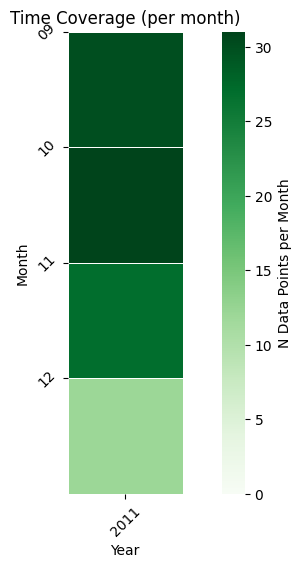

In [7]:
plot_time_coverage(ds, time_var="TIME")

## Plot a gridded variable

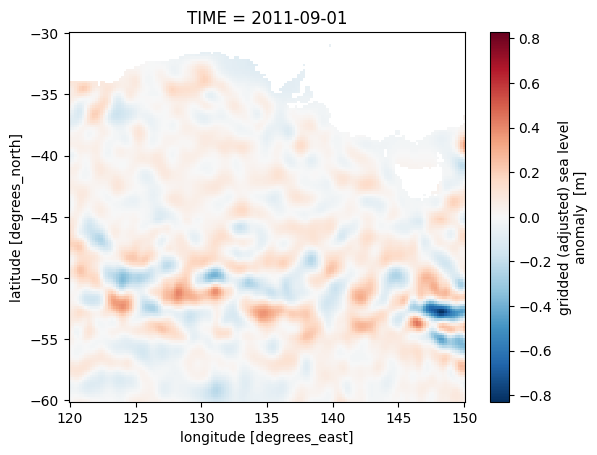

In [8]:
ds.GSLA.sel(TIME='2011-09-01T00:00:00.000000000', LONGITUDE=slice(120, 150), LATITUDE=slice(-60, -30)).plot()  # LATITUDE slice is reversed order from L3S

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

import pandas as pd

def plot_gsla_timeseries_subplots(ds, time_start, lon_slice, lat_slice):
    """
    Create subplots of timeseries data over specified time intervals and spatial slices.

    Parameters:
    - ds (xarray.Dataset): Dataset containing the variable of interest (e.g., GSLA).
    - time_start (str): Start time in 'YYYY-MM-DD' format.
    - lon_slice (slice): Longitude slice (e.g., slice(120, 150)).
    - lat_slice (slice): Latitude slice (e.g., slice(-60, -30)).
    """
    ds = ds.sortby("TIME")

    # Parse start time string to datetime
    start_time = pd.to_datetime(time_start)

    # Create a new figure with specified number of subplots in a row
        # Create a 3x2 grid of subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

    # Plot data on each subplot. We're plotting the next 6 time stamps (requiring obviously that they all exist)
    ii = 0
    iTime = list(ds.TIME.values).index(ds.sel(TIME=time_start , method='nearest').TIME)
    cbar_ax = fig.add_axes([0.99, 0.1, 0.02, 0.8])  # Adjust the position and size of the colorbar
    
    for i in range(3):
        for j in range(2):
            time_index = iTime + ii
            gsla = ds.GSLA.isel(TIME=time_index).sel(LONGITUDE=lon_slice, LATITUDE=lat_slice)
            uData = ds.UCUR.isel(TIME=time_index).sel(LONGITUDE=lon_slice, LATITUDE=lat_slice)
            vData = ds.VCUR.isel(TIME=time_index).sel(LONGITUDE=lon_slice, LATITUDE=lat_slice)
            lonData = gsla.LONGITUDE.values
            latData = gsla.LATITUDE.values

            cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'])

            p = axes[i, j].pcolor(lonData, latData, gsla, cmap=cmap_custom, vmin=-.5, vmax=.5)
            #axes[i, j].quiver(lonData, latData, uData, vData, units='width')
            axes[i, j].set_title(f'{np.datetime_as_string(ds.TIME.values[iTime + ii])}')
            ii += 1

    # Add a common colorbar
    fig.colorbar(p, cax=cbar_ax, label='GSLA')

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_1742601/2182299496.py:48: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(p, cax=cbar_ax, label='GSLA')
/tmp/ipykernel_1742601/2182299496.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


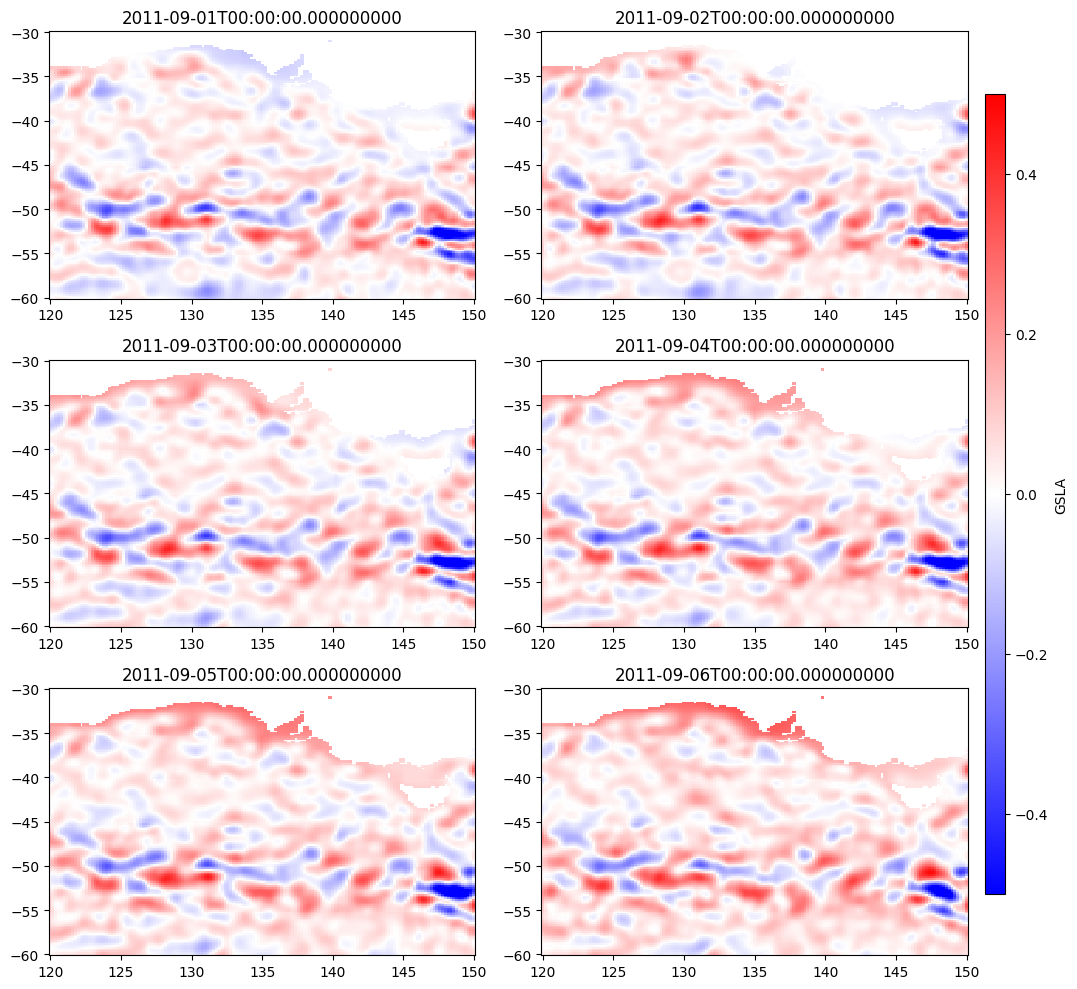

In [10]:
time_start = '2011-03-02'
lon_slice = slice(120, 150)
lat_slice = slice(-60, -30)

plot_gsla_timeseries_subplots(ds, time_start, lon_slice, lat_slice)
